# 0: Importiamo le librerie

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(threshold=np.inf)

# 1: Regressione Lineare Semplice Polinomiale

## 1.1: Definiamo le funzioni

In [6]:
# Definiamo la funzione f(x, alpha) che prende in input il vettore alpha dei coefficienti e un valore x
def f(x, alpha):
    d = alpha.shape[0] - 1 # Abbiamo detto che la shape di alpha è (d+1, )
    y = np.zeros_like(x)
    for i in range(d+1):
        y = y + alpha[i] * x ** i
    return y

def vandermonde(x, k):
    n = x.shape[0]
    X = np.zeros((n, k+1)) # d+1 perchè le colonne vanno da x^0 a x^k
    for i in range(k+1):
        X[:, i] = x ** i # Prendi tutti gli elementi della prima colonna x^0
    return X

### 1.3.0 (facoltativo): calcoliamo tramite equazioni normali
Dobbiamo quindi trovare il valore di $\alpha$ che risolva $ \min_{\alpha} || X\alpha - y ||_2^2 $

Questo equivale a: $X^T X \alpha = X^T y$

Applichiamo la fattorizzazione LU: $X^T X = L U $

Il sistema dell equazioni normali può quindi essere risolto tramite il metodo della sostituzione all'Avanti e all'Indietro, ovvero risolvendo i due sistemi (triangolari):

$$
\begin{cases}
    L z = X^T y \\
    U \alpha = z.
\end{cases}
$$

In [7]:
def eqn(X, y):
    #Calcoliamo la matrice dei coefficienti delle equazioni normali
    XtX=X.T@X

    # Calcoliamo il termine noto X^T y
    Xty = X.T @ y

    # Troviamo z
    alpha_eqn= np.linalg.solve(XtX, Xty) # .solve calcola l'equazione Ax-b, con A=XtX e b=Xty
    return alpha_eqn

## 1.2: Risoluzione tramite SVD:
$$
X = U \Sigma V^T,
$$

Dove $U \in \mathbb{R}^{n \times n}$ e $V \in \mathbb{R}^{(d+1) \times (d+1)}$ sono matrici ortogonali, mentre $\Sigma \in \mathbb{R}^{n \times (d+1)}$ è una matrice diagonale i cui elementi sulla diagonale sono i valori singolari di $X$, in ordine decrescente.

Ricordando che le matrici $U$ e $V$ sono ortognali, le equazioni normali diventano:

$$
X^T X \alpha = X^T y \iff V \Sigma^2 V^T \alpha = V \Sigma U^T y \iff \Sigma^2 V^T \alpha = \Sigma U^T y
$$

La cui soluzione esplicita è:

$$
    \alpha = \sum_{i=1}^{d+1} \frac{u_i^T y}{\sigma_i} v_i. 
$$

In [8]:
def SVD (X, y, d):
    # Calcoliamo la dimensione della prima riga
    n_features = X.shape[0]
    
    # Calcoliamo la SVD di X
    U, s, VT = np.linalg.svd(X)

    # Costruiamo la matrice Sigma esplicitamente (per controllare che la SVD sia stata svolta correttamente)
    # Sigma = np.zeros((n_features, d+1))
    # for i in range(d+1):
    #     Sigma[i, i] = s[i]
    # print(Sigma) # Sigma È LA MATRICE DIAGONALE, HA ELEMENTI FINO A d+1

    # Inizializzazione di alpha (Controlla perchè d+1)
    alpha_svd = np.zeros((d+1, ))

    # Calcola alpha
    for i in range(d+1):
        uTy = U[:, i].T @ y
        v_i = VT[i, :]
        alpha_svd = alpha_svd + uTy / s[i] * v_i
    return alpha_svd

## 1.3: Definiamo i dati

In [21]:
d = 5 # Grado del polinomio
n = 15 # Numero di dati

# Definiamo alpha_true = (1, 1, ..., 1) 
alpha_true = np.ones((d+1,))

# Scegliamo un valore di x
x = np.linspace(0, 1, n)
X = vandermonde(x, d) # Questa matrice ha il rango massimo!!!
# Se non ha il rango massimo, il metodo SVD ci darà tante soluzioni diverse

# Generiamo il rumore
sig = 0.1
e = np.random.normal(loc=0, scale=sig, size=(n, ))

# Inizializziamo e calcoliamo le y_i
y = np.zeros_like(x)
for i in range(n):
    y[i] = f(x[i], alpha_true) + e[i]

alpha_eqn = eqn(X, y)
alpha_svd = SVD(X, y, d)

## 1.4: Grafico

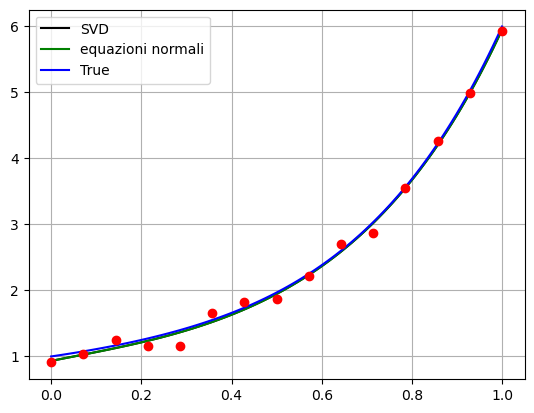

In [22]:

# Rappresentiamo tutte le soluzioni su grafico
xx = np.linspace(0, 1, 100)
yy_true = f(xx, alpha_true)
yy_eqn = f(xx, alpha_eqn)
yy_svd = f(xx, alpha_svd)

plt.plot(xx, yy_svd, 'k')
plt.plot(xx, yy_eqn, 'g')
plt.plot(xx, yy_true, 'b')
plt.plot(x, y, 'ro')
plt.legend(["SVD", "equazioni normali", "True"])
plt.grid()
plt.show()
# DA NOTARE CHE SE ABBIAMO IL RANGO MASSIMO (come in questo caso) EQUAZIONI NORMALI E SVD HANNO LO STESSO RISULTATO!!!

## 1.5: Database di Kaggle

In [28]:
nome_file = 'Salary_dataset.csv'
df_salary = pd.read_csv(nome_file)

print("\nPrime 5 righe del dataset:")
print(df_salary.head())

X = df_salary[['YearsExperience']].values
y = df_salary['Salary'].values

d_salary = 15





Prime 5 righe del dataset:
   Unnamed: 0  YearsExperience   Salary
0           0              1.2  39344.0
1           1              1.4  46206.0
2           2              1.6  37732.0
3           3              2.1  43526.0
4           4              2.3  39892.0
